In [1]:
from prophet import Prophet
from innov8.db_ops import data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

2024-08-24 18:33:04.413 | INFO     | innov8.db_ops:load_main_table:421 - Loading main table...


In [2]:
import logging

# Fit a model to trigger cmdstanpy before setting logging level
Prophet().fit(pd.DataFrame({"ds": ["2022-01-01", "2022-01-02"], "y": [0, 1]}))
# Suppress logging from cmdstanpy
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

18:33:07 - cmdstanpy - INFO - Chain [1] start processing
18:33:07 - cmdstanpy - INFO - Chain [1] done processing


In [3]:
data = data.main_table[["symbol", "date", "open", "high", "low", "close", "volume"]]
data

,symbol,date,open,high,low,close,volume
0,A,2022-07-01,117.990277,118.953748,115.914344,118.407448,1119800
1,A,2022-07-05,116.957280,119.867555,115.705760,119.748360,1484900
2,A,2022-07-06,119.986743,121.516368,119.748353,120.364182,1642300
3,A,2022-07-07,120.175461,122.390451,119.807957,122.320923,1221200
4,A,2022-07-08,120.145658,122.380511,120.145658,121.685226,1267300
...,...,...,...,...,...,...,...
269487,ZTS,2024-08-19,183.800003,184.520004,182.559998,184.479996,1637000
269488,ZTS,2024-08-20,184.479996,184.759995,182.899994,183.600006,1186400
269489,ZTS,2024-08-21,184.270004,184.529999,181.820007,182.899994,1246800
269490,ZTS,2024-08-22,183.410004,184.350006,181.509995,182.169998,1135800


TODO: remove delisted tickers

In [4]:
data.groupby("symbol").count()["date"].value_counts()

date
540    493
251      6
298      1
424      1
539      1
505      1
Name: count, dtype: int64

In [5]:
def filter_symbols_with_max_dates(df):
    value_counts = df['symbol'].value_counts()

    # Filter the DataFrame to keep only symbols lagging behind the max by at most 5 days
    symbols_with_max_dates = value_counts[value_counts >= value_counts.max()-5].index
    filtered_df = df[df['symbol'].isin(symbols_with_max_dates)]
    return filtered_df

data = filter_symbols_with_max_dates(data)
data

,symbol,date,open,high,low,close,volume
0,A,2022-07-01,117.990277,118.953748,115.914344,118.407448,1119800
1,A,2022-07-05,116.957280,119.867555,115.705760,119.748360,1484900
2,A,2022-07-06,119.986743,121.516368,119.748353,120.364182,1642300
3,A,2022-07-07,120.175461,122.390451,119.807957,122.320923,1221200
4,A,2022-07-08,120.145658,122.380511,120.145658,121.685226,1267300
...,...,...,...,...,...,...,...
269487,ZTS,2024-08-19,183.800003,184.520004,182.559998,184.479996,1637000
269488,ZTS,2024-08-20,184.479996,184.759995,182.899994,183.600006,1186400
269489,ZTS,2024-08-21,184.270004,184.529999,181.820007,182.899994,1246800
269490,ZTS,2024-08-22,183.410004,184.350006,181.509995,182.169998,1135800


In [47]:
def generate_forecast(symbol: str) -> None:
    df = data

    forecasts = {}
    periods = 5
    for price_type in ["open", "high", "low", "close"]:
        # Prepare the dataframe for Prophet
        df_prophet = df.loc[df["symbol"] == symbol, ["date", price_type]].rename(
            columns={"date": "ds", price_type: "y"}
        )
        
        # Get the last period values
        last_period = df_prophet.diff().abs()['y'].tail(periods).to_numpy()
        last_price = df_prophet.iat[-1, 1]
        s = last_period.sum()
        price_diffs = np.resize(last_period, 10)

        # Initialize and fit the Prophet model
        model = Prophet()
        model.fit(df_prophet)

        # Create a dataframe for future dates
        future = model.make_future_dataframe(
            periods=periods, freq="B"
        )  # 'B' is for business days
        forecast = model.predict(future)

        predictions = forecast[["ds", "yhat"]].tail(periods)
        for i in range(periods):
            r = s/periods
            price = predictions.iat[i, 1].clip(last_price - r, last_price + r)
            price_diffs[i+periods] = abs(price-last_price)
            last_price = price
            s = s - price_diffs[i] + price
            predictions.iat[i, 1] = price
        forecasts[price_type] = predictions


    # Store relevant data in the database
    for i in range(periods):
        forecast_date = (
            forecasts["open"].iloc[i]["ds"].tz_localize(None).timestamp()
        )
        forecast_open = forecasts["open"].iloc[i]["yhat"]
        forecast_high = forecasts["high"].iloc[i]["yhat"]
        forecast_low = forecasts["low"].iloc[i]["yhat"]
        forecast_close = forecasts["close"].iloc[i]["yhat"]
        
generate_forecast("AAPL")

In [10]:
train_size = 0.8


def train_test_split_group(group):
    train_index = int(len(group) * train_size)
    train = group.iloc[:train_index]
    test = group.iloc[train_index:]
    return train, test


train_list = []
test_list = []

for _, group in data.groupby("symbol"):
    train, test = train_test_split_group(group)
    train_list.append(train)
    test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

In [23]:
def fit_prophet_model(train_df, column):
    train_df = train_df[["date", column]].rename(columns={"date": "ds", column: "y"})

    model = Prophet()
    model.fit(train_df)

    return model


def predict_prophet_model(test_df, column, model):
    test_df = test_df[["date", column]].rename(columns={"date": "ds", column: "y"})

    future = model.make_future_dataframe(periods=len(test_df), freq="B")
    forecast = model.predict(future)

    predictions = forecast[["ds", "yhat"]].iloc[-len(test_df) :]

    return predictions


# Store the average MAPE
average_mape = {column: [] for column in ["open", "high", "low", "close", "volume"]}

# Calculate the MAPE for each symbol and column
symbols = data["symbol"].unique()
for symbol in symbols:
    train_symbol_data = train_df[train_df["symbol"] == symbol]
    test_symbol_data = test_df[test_df["symbol"] == symbol]
    for column in ["open", "high", "low", "close", "volume"]:
        model = fit_prophet_model(train_symbol_data, column)
        predictions = predict_prophet_model(test_symbol_data, column, model)
        mape = mean_absolute_percentage_error(
            test_symbol_data[column].values, predictions["yhat"]
        )
        average_mape[column].append(mape)
    break

# Calculate the average and standard deviation for each column
average_scores = {
    column: {
        "mape_mean": np.mean(average_mape[column]),
        "mape_std": np.std(average_mape[column]),
    }
    for column in ["open", "high", "low", "close", "volume"]
}

# Plotting the MAPE results
fig, ax = plt.subplots(1, len(average_scores), figsize=(18, 6))

for idx, (column, scores) in enumerate(average_scores.items()):
    sns.barplot(
        x=[column],
        y=[scores["mape_mean"]],
        yerr=[scores["mape_std"]],
        capsize=0.1,
        ax=ax[idx],
    )
    ax[idx].set_title(f"Average MAPE for {column}")
    ax[idx].set_ylabel("MAPE")
    ax[idx].set_xlabel(column)

plt.tight_layout()
plt.show()
average_scores


NameError: name 'train_df' is not defined

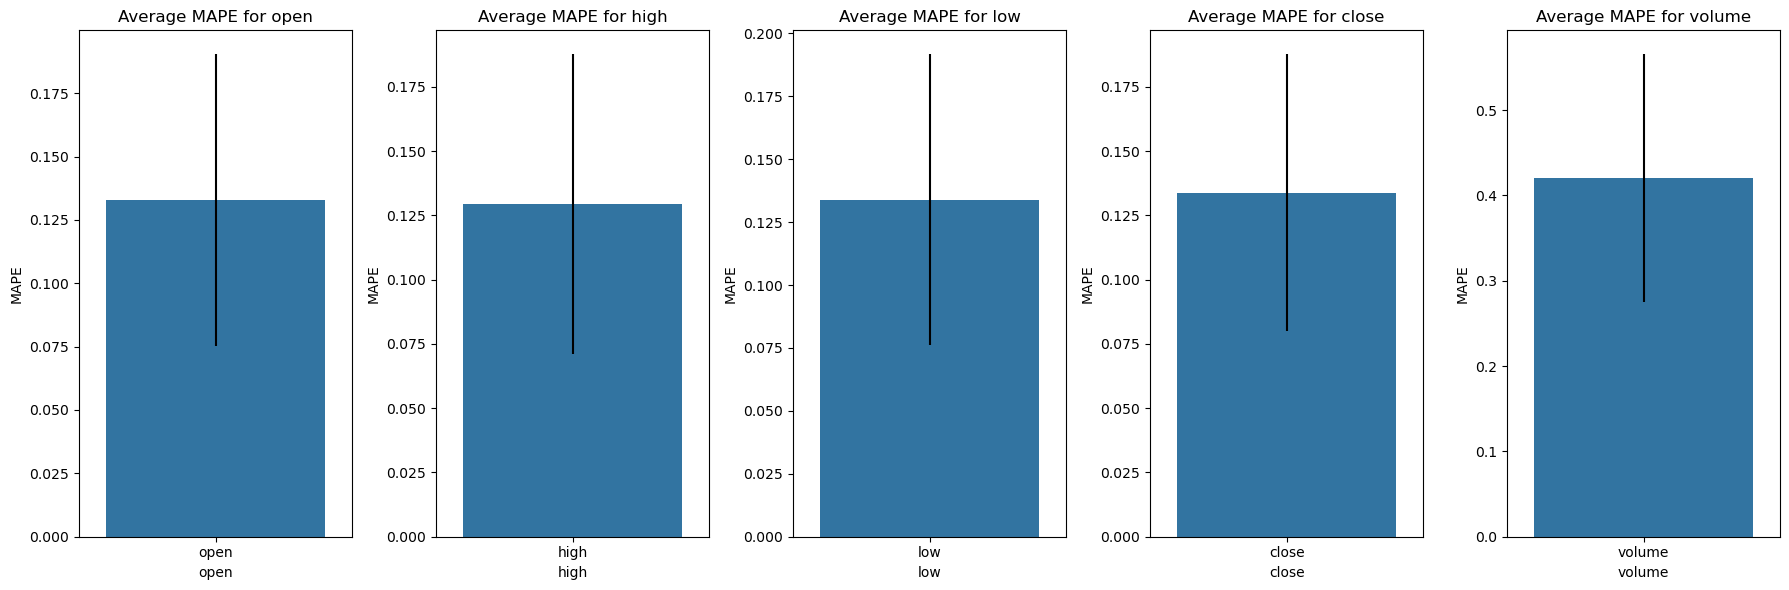

In [15]:
from sklearn.model_selection import TimeSeriesSplit

def fit_prophet_model(train_df, column):
    train_df = train_df[["date", column]].rename(columns={"date": "ds", column: "y"})
    model = Prophet()
    model.fit(train_df)
    return model

def predict_prophet_model(test_df, column, model):
    test_df = test_df[["date", column]].rename(columns={"date": "ds", column: "y"})
    future = model.make_future_dataframe(periods=len(test_df), freq="B")
    forecast = model.predict(future)
    predictions = forecast[["ds", "yhat"]].iloc[-len(test_df):]
    predictions = adjust_predictions_based_on_rolling_max_diff(predictions, test_df, column)
    return predictions

def adjust_predictions_based_on_rolling_max_diff(predictions, test_df, column):
    adjusted_predictions = []

    for i in range(len(predictions)):
        # Determine the relevant slice of test_df for calculating the max difference
        past_data = test_df[column].iloc[max(0, i-3):i+1]
        
        if len(past_data) > 1:  # Ensure there is enough data to calculate the difference
            max_diff = past_data.diff().abs().max()
            last_known_value = test_df[column].iloc[i]

            # Define the range based on the last known value and max_diff
            min_value = last_known_value - max_diff
            max_value = last_known_value + max_diff
        else:
            # If not enough past data, do not clip
            min_value = -np.inf
            max_value = np.inf

        # Adjust prediction based on the calculated range
        adjusted_yhat = np.clip(predictions["yhat"].iloc[i], min_value, max_value)
        adjusted_predictions.append(adjusted_yhat)
    
    predictions["adjusted_yhat"] = adjusted_predictions
    return predictions

# Store the average MAPE
average_mape = {column: [] for column in ["open", "high", "low", "close", "volume"]}

# Calculate the MAPE for each symbol and column using TimeSeriesSplit
symbols = data["symbol"].unique()

for symbol in symbols:
    symbol_data = data[data["symbol"] == symbol]
    
    tscv = TimeSeriesSplit(n_splits=5)  # Number of splits, adjust as needed
    for train_index, test_index in tscv.split(symbol_data):
        train_symbol_data = symbol_data.iloc[train_index]
        test_symbol_data = symbol_data.iloc[test_index]
        
        for column in ["open", "high", "low", "close", "volume"]:
            model = fit_prophet_model(train_symbol_data, column)
            predictions = predict_prophet_model(test_symbol_data, column, model)
            mape = mean_absolute_percentage_error(
                test_symbol_data[column].values, predictions["yhat"]
            )
            average_mape[column].append(mape)
    break

# Calculate the average and standard deviation for each column
average_scores = {
    column: {
        "mape_mean": np.mean(average_mape[column]),
        "mape_std": np.std(average_mape[column]),
    }
    for column in ["open", "high", "low", "close", "volume"]
}

# Plotting the MAPE results
fig, ax = plt.subplots(1, len(average_scores), figsize=(18, 6))

for idx, (column, scores) in enumerate(average_scores.items()):
    sns.barplot(
        x=[column],
        y=[scores["mape_mean"]],
        yerr=[scores["mape_std"]],
        capsize=0.1,
        ax=ax[idx],
    )
    ax[idx].set_title(f"Average MAPE for {column}")
    ax[idx].set_ylabel("MAPE")
    ax[idx].set_xlabel(column)

plt.tight_layout()
plt.show()


In [35]:
average_scores

{'open': {'mape_mean': 0.09673153851727577, 'mape_std': 0.0732144571225796},
 'high': {'mape_mean': 0.09780860006497626, 'mape_std': 0.0735042551339054},
 'low': {'mape_mean': 0.10052716882148077, 'mape_std': 0.07622310885218071},
 'close': {'mape_mean': 0.1004524853080539, 'mape_std': 0.07501980438877076},
 'volume': {'mape_mean': 4.124401689424091e+17,
  'mape_std': 1.93076480163587e+19}}

In [177]:
def fit_prophet_model(train_df, column):
    train_df = train_df[["date", column]].rename(columns={"date": "ds", column: "y"})

    model = Prophet()
    model.fit(train_df)
    df_cv = cross_validation(model, initial=f'{len(train_df)} days', period='30 days', horizon = '5 days', parallel="processes")

    return model, df_cv


def predict_prophet_model(test_df, column, model):
    test_df = test_df[["date", column]].rename(columns={"date": "ds", column: "y"})

    future = model.make_future_dataframe(periods=len(test_df), freq="B")
    forecast = model.predict(future)

    predictions = forecast[["ds", "yhat"]].iloc[-len(test_df) :]

    return predictions


# Store the average MAPE
average_mape = {column: [] for column in ["open", "high", "low", "close", "volume"]}
cvs = {column: pd.DataFrame() for column in ["open", "high", "low", "close", "volume"]}

# Calculate the MAPE for each symbol and column
symbols = data["symbol"].unique()
for symbol in symbols:
    cv_data = data[data["symbol"] == symbol]
    for column in ["open", "high", "low", "close", "volume"]:
        model, df_cv = fit_prophet_model(cv_data, column)
        predictions = predict_prophet_model(cv_data, column, model)
        mape = mean_absolute_percentage_error(
            cv_data[column].values, predictions["yhat"]
        )
        average_mape[column].append(mape)
        cvs[column] = pd.concat([cvs[column], performance_metrics(df_cv, metrics=["mape", "mdape", "smape", "coverage"])], axis=0)

# Calculate the average and standard deviation for each column
average_scores = {
    column: {
        "mape_mean": np.mean(average_mape[column]),
        "mape_std": np.std(average_mape[column]),
    }
    for column in ["open", "high", "low", "close", "volume"]
}

average_scores

{'open': {'mape_mean': 0.32057946165731305, 'mape_std': 0.2943931833139793},
 'high': {'mape_mean': 0.32155098293020073, 'mape_std': 0.296745067882909},
 'low': {'mape_mean': 0.32506365676259524, 'mape_std': 0.29829656826746337},
 'close': {'mape_mean': 0.32329099989709587, 'mape_std': 0.296949202577944},
 'volume': {'mape_mean': 3341265306553511.0,
  'mape_std': 7.471296356315325e+16}}

In [178]:
for column in cvs:
    print(column)
    display(cvs[column].groupby("horizon").mean().T)


open


horizon,1 days,2 days,3 days,4 days,5 days
rmse,6.296646,6.558197,6.958581,8.853311,9.977046
mape,0.035255,0.036493,0.039092,0.045513,0.050064
mdape,0.033150,0.033710,0.039092,0.042213,0.045615
smape,0.034927,0.036622,0.039821,0.046185,0.050948
coverage,0.740519,0.701264,0.649701,0.574850,0.533599


high


horizon,1 days,2 days,3 days,4 days,5 days
rmse,6.485125,6.998809,6.595897,9.023009,9.927934
mape,0.035550,0.037774,0.036781,0.045218,0.048908
mdape,0.033099,0.034908,0.036781,0.042027,0.044490
smape,0.035385,0.038133,0.037350,0.045934,0.049744
coverage,0.710579,0.669328,0.666667,0.564205,0.538922


low


horizon,1 days,2 days,3 days,4 days,5 days
rmse,6.281036,6.708136,7.063461,8.928820,10.004973
mape,0.035179,0.037418,0.040208,0.047275,0.050382
mdape,0.032835,0.034235,0.040208,0.044755,0.045784
smape,0.035057,0.037792,0.041086,0.048185,0.051239
coverage,0.755822,0.701264,0.639721,0.548902,0.539587


close


horizon,1 days,2 days,3 days,4 days,5 days
rmse,6.380276,7.217074,6.814600,9.157377,9.709722
mape,0.035634,0.039141,0.038762,0.047533,0.048638
mdape,0.033311,0.035947,0.038762,0.044775,0.044049
smape,0.035647,0.039802,0.039492,0.048444,0.049444
coverage,0.730539,0.666001,0.670659,0.546906,0.556886


volume


horizon,1 days,2 days,3 days,4 days,5 days
rmse,1.780664e+06,1.643805e+06,1.608054e+06,1.497917e+06,3.002858e+06
mape,3.917295e-01,3.477872e-01,4.108147e-01,3.107870e-01,3.533118e-01
mdape,3.417418e-01,3.093936e-01,4.108147e-01,2.716625e-01,3.315785e-01
smape,3.249306e-01,2.979564e-01,3.265099e-01,2.714342e-01,3.906617e-01
coverage,8.822355e-01,9.048570e-01,8.932136e-01,9.248170e-01,7.292083e-01


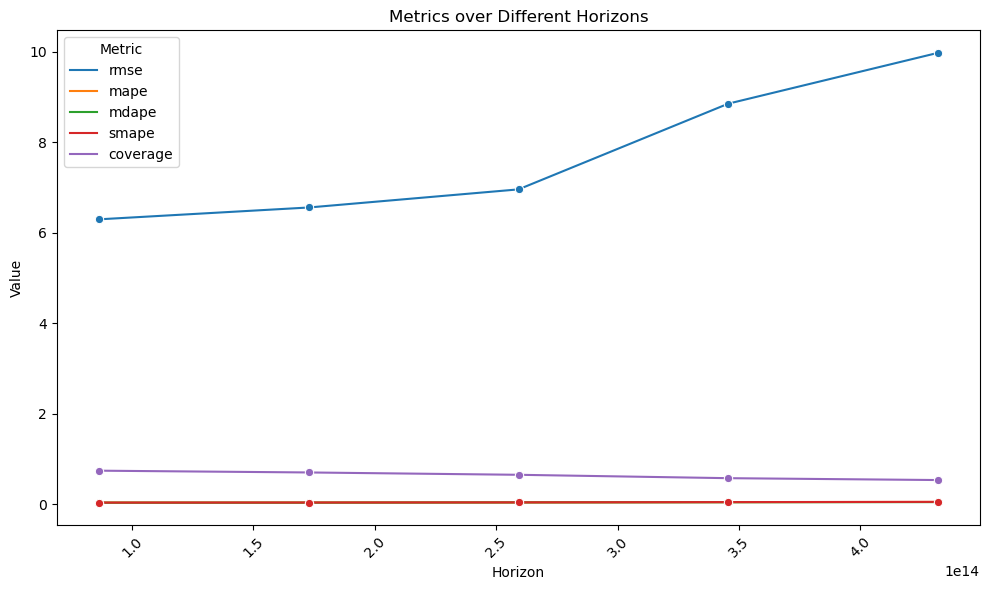

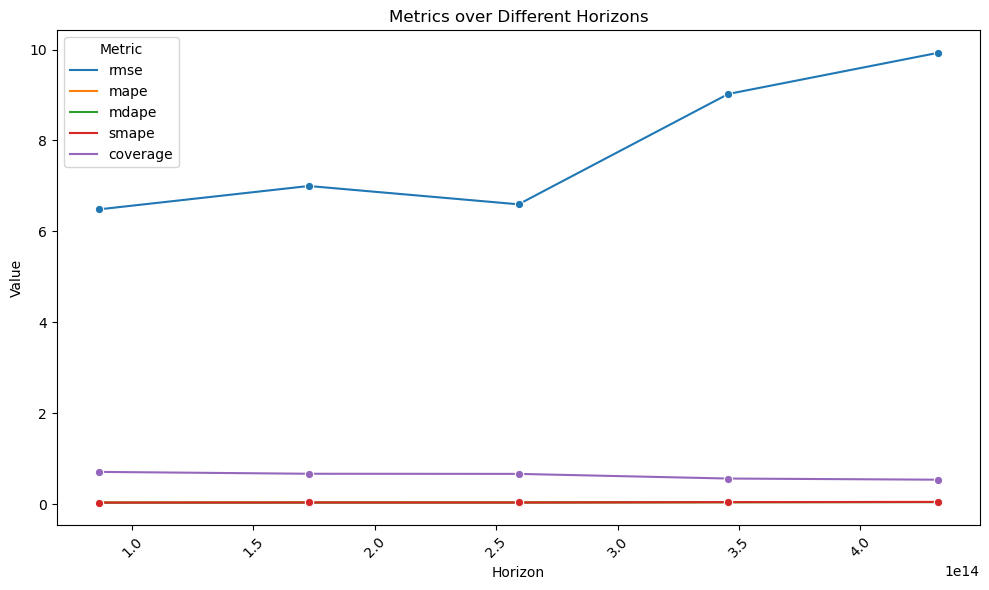

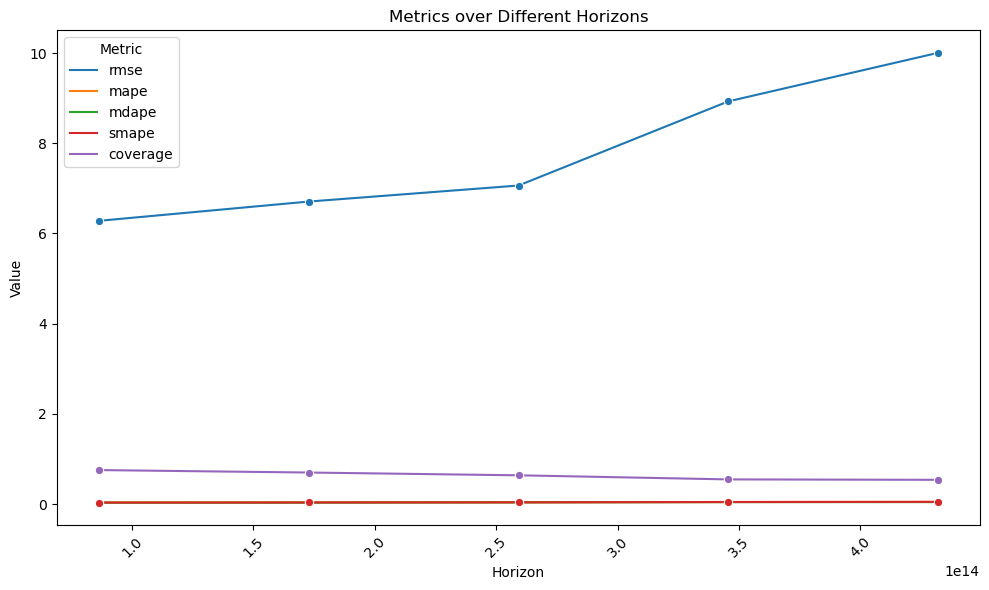

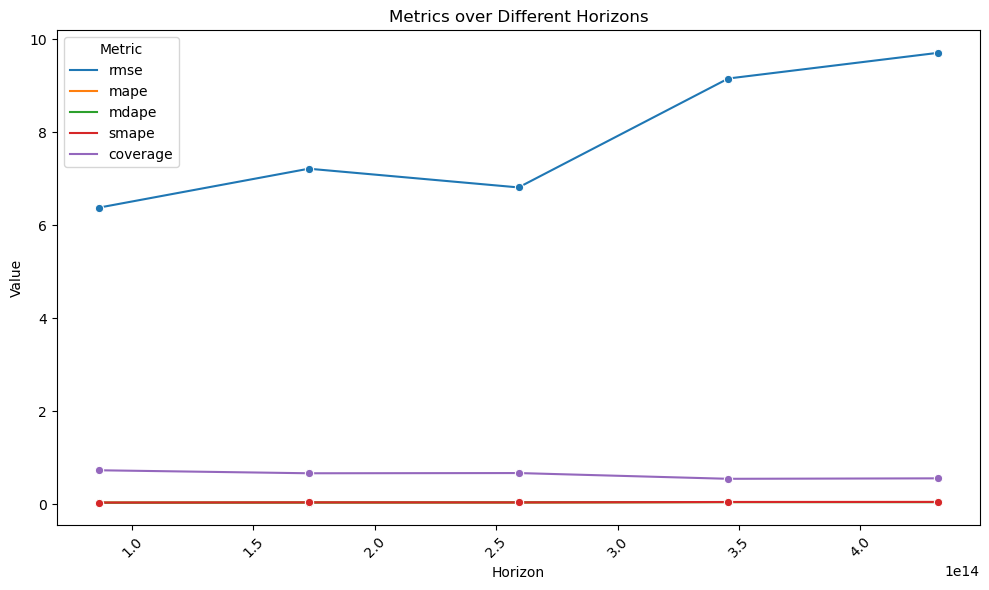

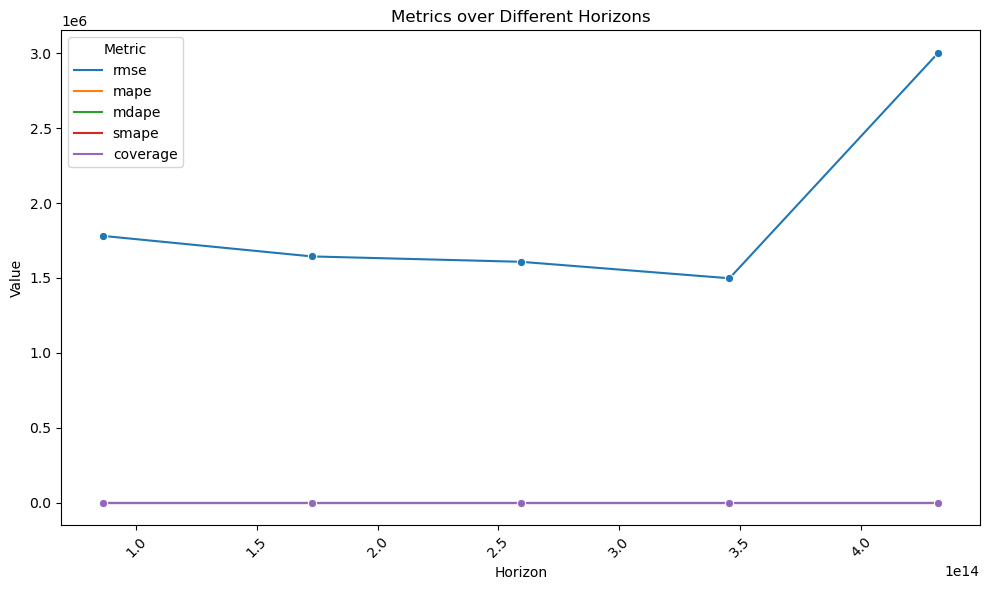

In [192]:
for column in cvs:
    df_melted = cvs[column].groupby("horizon").mean().reset_index().melt(id_vars="horizon", var_name="metric", value_name="value")

    # Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_melted, x="horizon", y="value", hue="metric", marker="o")

    plt.title("Metrics over Different Horizons")
    plt.ylabel("Value")
    plt.xlabel("Horizon")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.tight_layout()

    plt.show()


In [27]:
def fit_prophet_model(train_df, column):
    train_df = train_df[["date", column]].rename(columns={"date": "ds", column: "y"})

    model = Prophet()
    model.fit(train_df)

    return model


def predict_prophet_model(test_df, column, model):
    test_df = test_df[["date", column]].rename(columns={"date": "ds", column: "y"})

    future = model.make_future_dataframe(periods=len(test_df), freq="B")
    forecast = model.predict(future)

    predictions = forecast[["ds", "yhat"]].iloc[-len(test_df) :]

    return predictions


# Store the average MAPE
average_mape = {column: [] for column in ["open", "high", "low", "close", "volume"]}

# Calculate the MAPE for each symbol and column
symbols = data["symbol"].unique()
for symbol in symbols:
    cv_data = data[data["symbol"] == symbol]
    # train_symbol_data = train_df[train_df["symbol"] == symbol]
    # test_symbol_data = test_df[test_df["symbol"] == symbol]
    for column in ["open", "high", "low", "close", "volume"]:
        # model = fit_prophet_model(train_symbol_data, column)
        model = fit_prophet_model(cv_data, column)
        predictions = predict_prophet_model(cv_data, column, model)
        mape = mean_absolute_percentage_error(
            cv_data[column].values, predictions["yhat"]
        )
        average_mape[column].append(mape)

# Calculate the average and standard deviation for each column
average_scores = {
    column: {
        "mape_mean": np.mean(average_mape[column]),
        "mape_std": np.std(average_mape[column]),
    }
    for column in ["open", "high", "low", "close", "volume"]
}

average_scores


{'open': {'mape_mean': 0.5857606768682575, 'mape_std': 0.8797219182800429},
 'high': {'mape_mean': 0.5848731006165843, 'mape_std': 0.8178172695589382},
 'low': {'mape_mean': 0.5900832402233751, 'mape_std': 0.9506069911876511},
 'close': {'mape_mean': 0.5888602481205287, 'mape_std': 0.9036663564919489},
 'volume': {'mape_mean': 2.57686020014161e+16,
  'mape_std': 5.7215581672298086e+17}}

In [ ]:
def fit_prophet_model(train_df, column):
    train_df = train_df.copy()
    # First differencing to calculate returns and dropping the first NaN value
    train_df.loc[:, 'y_diff'] = train_df[column].diff().dropna()
    train_df = train_df[["date", "y_diff"]].rename(columns={"date": "ds", "y_diff": "y"})
    
    model = Prophet()
    model.fit(train_df)
    df_cv = cross_validation(model, initial=f'{len(train_df)} days', period='30 days', horizon='5 days', parallel="processes")
    
    return model, df_cv


def predict_prophet_model(test_df, column, model, last_train_price):
    # Predict returns
    future = model.make_future_dataframe(periods=len(test_df), freq="B")
    forecast = model.predict(future)
    
    # Select only the predictions corresponding to the test period
    forecast_test_period = forecast.iloc[-len(test_df):].copy()
    
    # Cumulative sum of predicted returns for the test period to get price
    forecast_test_period.loc[:, 'yhat_cumsum'] = forecast_test_period['yhat'].cumsum()
    
    # Calculate predicted prices
    forecast_test_period.loc[:, 'yhat_price'] = last_train_price + forecast_test_period['yhat_cumsum']
    
    predictions = forecast_test_period[["ds", "yhat_price"]]
    
    return predictions


# Store the average MAPE
average_mape = {column: [] for column in ["open", "high", "low", "close", "volume"]}
cvs = {column: pd.DataFrame() for column in ["open", "high", "low", "close", "volume"]}

# Calculate the MAPE for each symbol and column
symbols = data["symbol"].unique()
for symbol in symbols:
    cv_data = data[data["symbol"] == symbol]
    for column in ["open", "high", "low", "close", "volume"]:
        # Fit the model on the returns
        model, df_cv = fit_prophet_model(cv_data, column)
        
        # Get the last price from the training data to start prediction
        last_train_price = cv_data[column].iloc[-1]
        
        # Predict the prices using the predicted returns
        predictions = predict_prophet_model(cv_data, column, model, last_train_price)
        
        # Calculate MAPE for the price predictions
        mape = mean_absolute_percentage_error(cv_data[column].values, predictions["yhat_price"])
        average_mape[column].append(mape)
        
        # Store the cross-validation performance metrics
        cvs[column] = pd.concat([cvs[column], performance_metrics(df_cv, metrics=["mape", "mdape", "smape", "coverage"])], axis=0)
    break

# Calculate the average and standard deviation for each column
average_scores = {
    column: {
        "mape_mean": np.mean(average_mape[column]),
        "mape_std": np.std(average_mape[column]),
    }
    for column in ["open", "high", "low", "close", "volume"]
}

average_scores


{'open': {'mape_mean': 0.3459323140954166, 'mape_std': 0.0},
 'high': {'mape_mean': 0.3569790909344873, 'mape_std': 0.0},
 'low': {'mape_mean': 0.4157631997650982, 'mape_std': 0.0},
 'close': {'mape_mean': 0.2561891928564564, 'mape_std': 0.0},
 'volume': {'mape_mean': 2.9060912521577236, 'mape_std': 0.0}}

In [8]:
for column in cvs:
    print(column)
    display(cvs[column].groupby("horizon").mean().T)


open


horizon,1 days,2 days,3 days,4 days,5 days
mape,451.435097,3416.025480,1483.896741,598.920051,972.291085
mdape,1.120490,1.143593,1.247895,1.238348,1.215977
smape,1.483749,1.525238,1.583003,1.570886,1.500140
coverage,0.894737,0.854858,0.851552,0.835020,0.861673


high


horizon,1 days,2 days,3 days,4 days,5 days
mape,579.480613,1289.688189,449.187933,410.082082,931.272228
mdape,1.228081,1.228141,1.288119,1.333125,1.273839
smape,1.521373,1.535591,1.541268,1.527029,1.538202
coverage,0.906208,0.852159,0.853576,0.853239,0.821188


low


horizon,1 days,2 days,3 days,4 days,5 days
mape,2020.450607,373.945449,1382.567122,979.847221,78.220242
mdape,1.262283,1.238239,1.253236,1.350316,1.286795
smape,1.459048,1.546138,1.573966,1.514619,1.453028
coverage,0.902159,0.859244,0.823212,0.867746,0.854251


close


horizon,1 days,2 days,3 days,4 days,5 days
mape,2.240496,2.552668,2.096320,1.924801,2.261682
mdape,1.284012,1.194021,1.195771,1.198365,1.196529
smape,1.551809,1.570428,1.576742,1.512670,1.554062
coverage,0.890688,0.864980,0.811066,0.847841,0.820175


volume


horizon,1 days,2 days,3 days,4 days,5 days
mape,2.326574,2.334865,3.017144,3.405290,1.763841
mdape,1.141170,1.067974,1.152366,1.179258,1.053593
smape,1.491282,1.579444,1.517026,1.557744,1.525826
coverage,0.917341,0.825236,0.904858,0.906545,0.820175


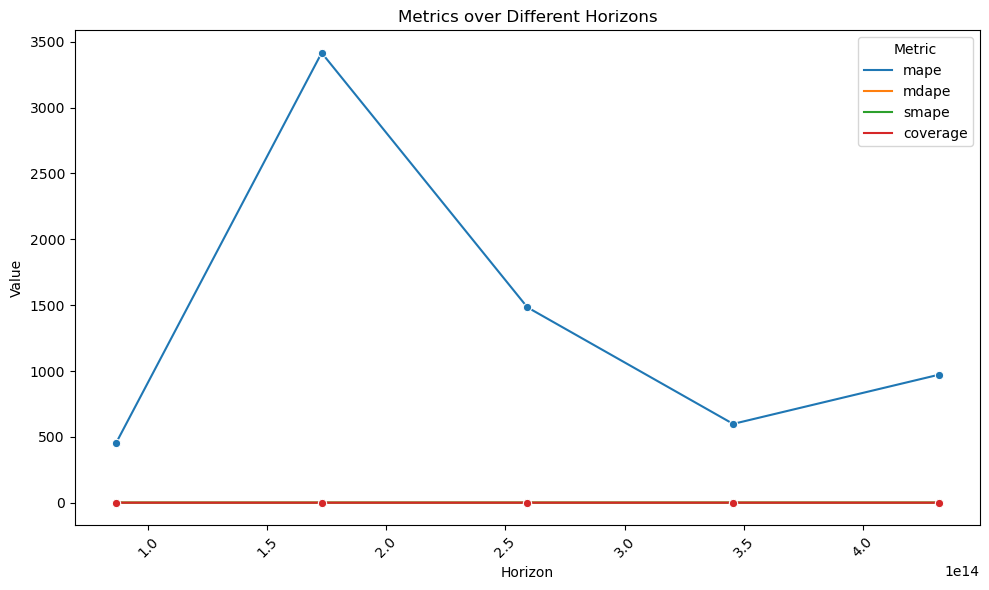

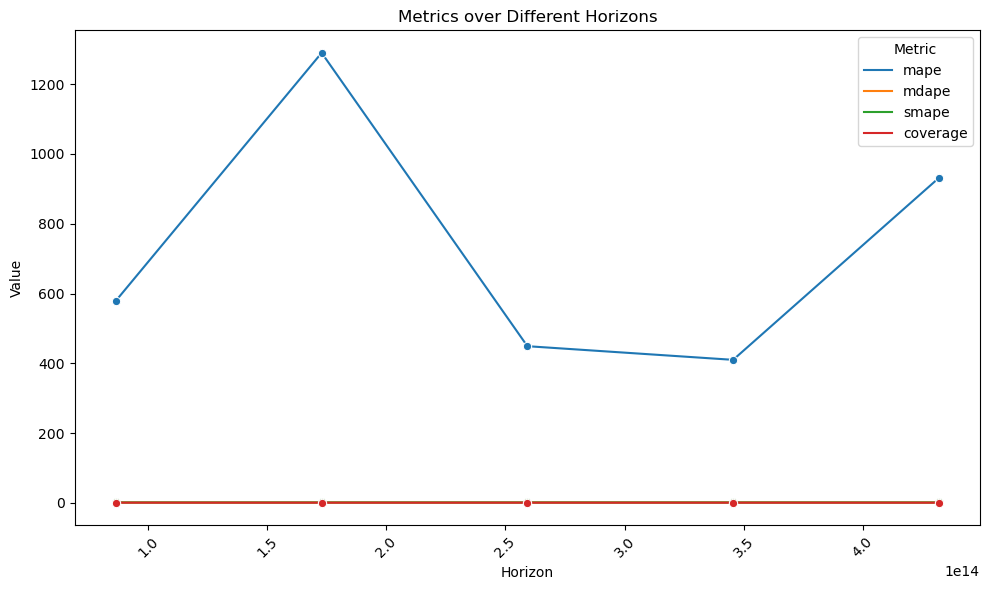

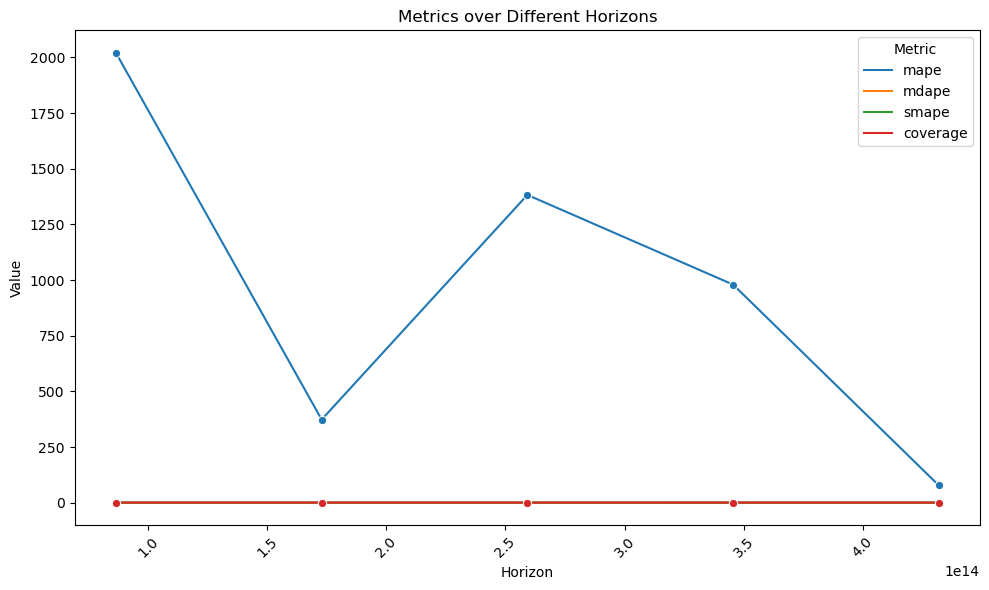

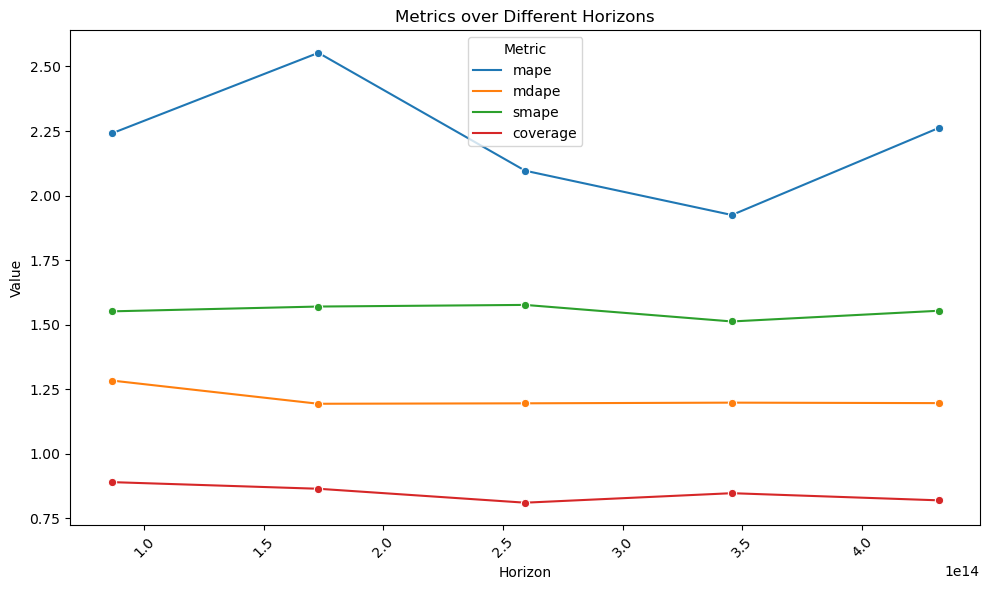

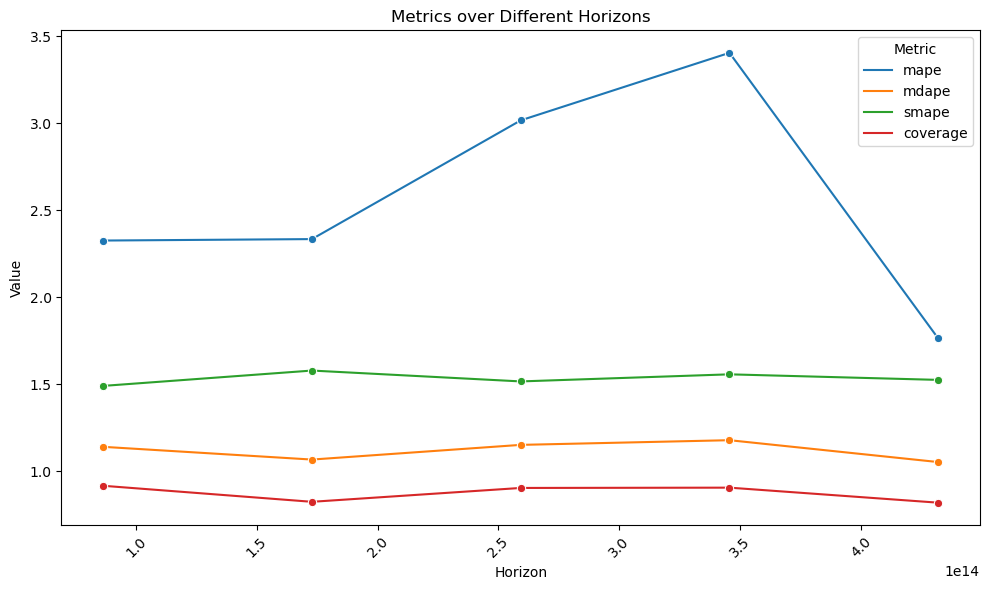

In [9]:
for column in cvs:
    df_melted = cvs[column].groupby("horizon").mean().reset_index().melt(id_vars="horizon", var_name="metric", value_name="value")

    # Plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_melted, x="horizon", y="value", hue="metric", marker="o")

    plt.title("Metrics over Different Horizons")
    plt.ylabel("Value")
    plt.xlabel("Horizon")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.tight_layout()

    plt.show()
